In [25]:
import pandas as pd

# Prepocessing libraries
import emoji
import re
from langdetect import detect
from spellchecker import SpellChecker
import string
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

def detect_lang(text):
    """
    Detects the language of a story.

    Parameters
    ----------
    text : str
        The story to be processed.
    Returns
    -------
    lang : str
        The language of the story.
    """
    try:
        return detect(text)
    except:
        return 'unknown'
    
stop_words = set(stopwords.words('english'))
punc = set(string.punctuation)
lemma = WordNetLemmatizer()
tokenizer = WordPunctTokenizer()
spellcheck = SpellChecker()

def preprocess(text):
    """
    Preprocesses a story by removing emojis, punctuations, stopwords, spellchecking and lemmatizing the words.

    Parameters
    ----------
    text : str
        The story to be preprocessed.
    Returns
    -------
    processed_text : str
        The preprocessed story.
    """

    # regex to replace all consecutive occurences of punctuations with a single punctuation
    pattern = r'([' + re.escape(''.join(punc)) + r'])\1+'
    text = re.sub(pattern, r'\1', ''.join(text))

    # regex to remove all numbers
    text = re.sub(r'\d+', '', text)

    # tokenize the text
    tokens = tokenizer.tokenize(text.lower())
    # remove stopwords, punctuations, emojis, correct and lemmatize the words
    tokens = [spellcheck.correction(token) for token in tokens]
    tokens = [token for token in tokens if emoji.is_emoji(token) == False]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [token for token in tokens if token not in punc]
    tokens = [lemma.lemmatize(token) for token in tokens if token]

    processed_text = ' '.join(tokens)
    return processed_text

def preprocess_without_lemmatizing(text):
    """
    Preprocesses a story by removing emojis, punctuations, stopwords, spellchecking the words.

    Parameters
    ----------
    text : str
        The story to be preprocessed.
    Returns
    -------
    processed_text : str
        The preprocessed story.
    """

    # regex to replace all consecutive occurences of punctuations with a single punctuation
    pattern = r'([' + re.escape(''.join(punc)) + r'])\1+'
    text = re.sub(pattern, r'\1', ''.join(text))

    # regex to remove all numbers
    text = re.sub(r'\d+', '', text)

    # tokenize the text
    tokens = tokenizer.tokenize(text.lower())
    # remove stopwords, punctuations, emojis, correct and lemmatize the words
    tokens = [spellcheck.correction(token) for token in tokens]
    tokens = [token for token in tokens if emoji.is_emoji(token) == False]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [token for token in tokens if token not in punc]
    tokens = [token for token in tokens if token]

    processed_text = ' '.join(tokens)
    return processed_text

In [2]:
# read the data
file = open("data/stories.csv", "r")
stories_array = []

for line in file:
    stories_array.append(line)

file.close()

data = pd.DataFrame(stories_array, columns=['story'])

Demo: `preprocess()` on a story

In [3]:
print(data['story'][3494])
print(preprocess(data['story'][3494]))

I am an investigative journalist and did a research on the Sugar Mummy scam circus in Singapore. They all operate the same way. No one is what they say they are. I contacted 6 of the agents on Locanto and other sites via WhatsApp and they were all scammers. They might change names but one thing is for 100% sure. You will be scammed! Basically they have a pre-paid phone card with a generic profile photo. They all asure you they are not scammers. After giving them you name, age and civil status they will ask for 300-500 SGDs for a fee. They only accept bank transfer. Then when you have payed this they ask for 1400-1900 SGD for further fees and insurance. They promise you a BMW and a monthly salary of at least 10500 SGD and so on. My conclusion is "DON´T PAY ANYTHING" They are all scammers/fraudsters/liers. Don´t fall for any sweet talk or promises, you will be fooled and no sugar mummy is at the end of the rainbow. No matter who they say they are or that they have lots of clients that re

#### Data preprocessing

In [4]:
# add language column
data["language"] = data["story"].apply(detect_lang)

# filter out non-english stories
data = data[data["language"] == "en"]

# drop language column
data = data.drop(columns=["language"])

Test processing on dataframe of 5 stories

In [5]:
from tqdm.auto import tqdm # to show progress bar while iterating over the stories

tqdm.pandas(desc="Preprocessing stories", colour='#ffaaff')
data["story"][0:5].progress_apply(preprocess)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Preprocessing stories: 100%|██████████| 5/5 [00:01<00:00,  4.06it/s]


0    accepted friend request facebook common friend...
1    whatsapp message good morning baron ya receive...
2    met alan bumble claimed project manager synerg...
3    connected person named ano cab app june normal...
4    person online name june lee initially contacte...
Name: story, dtype: object

Preprocessing the data and saving it

In [6]:
preprocessed_data = data["story"].progress_apply(preprocess)
preprocessed_data.to_csv("data/preprocessed_stories_lemmatized.csv", index=False, header=False)

Preprocessing stories: 100%|██████████| 3489/3489 [08:01<00:00,  7.25it/s]  


Preprocessing the data without lemmatizing and saving it

In [7]:
preprocessed_data = data["story"].progress_apply(preprocess_without_lemmatizing)
preprocessed_data.to_csv("data/preprocessed_stories.csv", index=False, header=False)

Preprocessing stories: 100%|██████████| 3489/3489 [08:10<00:00,  7.12it/s]  


# Topic Modeling

## LDA


In [48]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

def calculate_perplexities(data, no_topics, min_df):
    """
    DEPRECATED: Not used in the project.

    Calculates the perplexities of LDA models with different number of topics.

    Parameters
    ----------
    data : pandas.Series
        The preprocessed stories.
    no_topics : int
        The maximum number of topics to be considered.
    min_df : int
        The minimum number of documents a word should appear in to be
        considered as a feature.
    Returns
    -------
    perplexities : list
        The list of perplexities of LDA models with different nu
    """

    progress_bar = tqdm(total=no_topics, desc='Calculating Perplexities', unit='model') # to show progress bar while iterating over the number of topics

    perplexities = []
    vectorized_data = CountVectorizer(min_df=min_df).fit_transform(data)

    for i in range(2, no_topics+1):
        lda = LatentDirichletAllocation(n_components=i, random_state=0)
        lda.fit(vectorized_data)
        perplexities.append(lda.perplexity(vectorized_data))
        progress_bar.update(1)
    
    progress_bar.close()
    return perplexities

# function to display the topics of a topic model
def display_topics(model, feature_names, no_top_words):
    # TODO: implement this function
    pass
            

def get_coherence_score(model, corpus, dictionary):
    """
    Calculates the coherence score of a topic model.

    Parameters
    ----------
    model : gensim.models.ldamodel.LdaModel
        The LDA model.
    corpus : list
        The list of preprocesses stories.
    dictionary : gensim.corpora.dictionary.Dictionary
        The dictionary of the corpus.
    Returns
    -------
    coherence_score : float
        The coherence score of the topic model.
    """

    # get the word2vec score of the topic model
    coherence_model_lda = CoherenceModel(model=model, texts=corpus, dictionary=dictionary, coherence='c_npmi')
    word2vec_score = coherence_model_lda.get_coherence()
    return word2vec_score

def get_cross_validation_data(dictionary, corpus, n_topics_range, min_dfs, max_dfs, alphas):
    """
    Performs cross validation to find the best hyperparameters for the topic model.

    Parameters
    ----------
    dictionary : gensim.corpora.dictionary.Dictionary
        The dictionary of the corpus.
    corpus : list
        The list of preprocessed stories.
    n_topics_range : list
        The range of number of topics to be considered.
    min_dfs : list
        The range of minimum document frequencies to be considered.
    max_dfs : list
        The range of maximum document frequencies to be considered.
    alphas : list
        The range of alpha values to be considered.
    Returns
    -------
    cross_validation_data : pandas.DataFrame
        The cross validation data.
    """

    cross_validation_data = pd.DataFrame(columns=['no_topics', 'min_df', 'max_df', 'alpha', 'coherence_score'])
    progress_bar = tqdm(total=len(n_topics_range)*len(min_dfs)*len(max_dfs)*len(alphas), desc='Cross Validation', unit='model') # to show progress bar while iterating over the hyperparameters

    # Grid search to find the best hyperparameters
    for no_topics in n_topics_range:
        for min_df in min_dfs:
            for max_df in max_dfs:
                for alpha in alphas:
                    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=no_topics, random_state=0, alpha=alpha)
                    coherence_score = get_coherence_score(lda, corpus, dictionary)
                    cross_validation_data = cross_validation_data.append({'no_topics': no_topics, 'min_df': min_df, 'max_df': max_df, 'alpha': alpha, 'coherence_score': coherence_score}, ignore_index=True)
                    progress_bar.update(1)
    
    progress_bar.close()
    return cross_validation_data

In [39]:
# Load data
data = pd.read_csv("data/preprocessed_stories.csv", header=None, names=["story"])
data_lemmatized = pd.read_csv("data/preprocessed_stories_lemmatized.csv", header=None, names=["story"])

# Preprocess for gensim
tokenized_data = data["story"].apply(lambda x: x.split())
tokenized_data_lemmatized = data_lemmatized["story"].apply(lambda x: x.split())

# Create Dictionary
id2word = corpora.Dictionary(tokenized_data)
id2word_lemmatized = corpora.Dictionary(tokenized_data_lemmatized)

# Term Document Frequency Matrix
corpus = [id2word.doc2bow(text) for text in tokenized_data]
corpus_lemmatized = [id2word_lemmatized.doc2bow(text) for text in tokenized_data_lemmatized]

# Build LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=10, random_state=0, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
lda_model_lemmatized = LdaModel(corpus=corpus_lemmatized, id2word=id2word_lemmatized, num_topics=10, random_state=0, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

In [56]:
# lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=5, random_state=0)

# print id2word content
print(id2word.token2id)

{'accepted': 0, 'accused': 1, 'alleged': 2, 'along': 3, 'amount': 4, 'amounts': 5, 'answering': 6, 'around': 7, 'asked': 8, 'asking': 9, 'assist': 10, 'assisting': 11, 'attempted': 12, 'avoid': 13, 'background': 14, 'ballooned': 15, 'banking': 16, 'basic': 17, 'becoming': 18, 'began': 19, 'behavior': 20, 'believable': 21, 'blackmail': 22, 'build': 23, 'came': 24, 'cause': 25, 'cautious': 26, 'cease': 27, 'ceased': 28, 'certain': 29, 'change': 30, 'chatted': 31, 'claimed': 32, 'close': 33, 'commission': 34, 'common': 35, 'communication': 36, 'company': 37, 'complete': 38, 'completing': 39, 'compromised': 40, 'concern': 41, 'concerns': 42, 'concerted': 43, 'conduct': 44, 'contact': 45, 'continue': 46, 'contract': 47, 'conversation': 48, 'decided': 49, 'demands': 50, 'details': 51, 'develop': 52, 'due': 53, 'effort': 54, 'emotional': 55, 'emotionally': 56, 'entangled': 57, 'even': 58, 'expletives': 59, 'face': 60, 'facebook': 61, 'feeling': 62, 'financial': 63, 'flags': 64, 'fortunately':

We need to vectorize the text data to feed it into the LDA model. We use the `CountVectorizer()`. This has a parameter `min_df` which stands for minimum document frequency. For example, if we set it to 0.01, it will ignore words that appear in less than 1% of the documents.

There are also words that appear too often in the documents. `CountVectorizer()` has a parameter `max_df` to ignore the words that appear too freuqently. For example, if we set it to 0.95, it will ignore words that appear in more than 95% of the documents.

We also need to determine the optimal number of topics. For that, we compute the coherence value for different number of topics and choose the one with the highest coherence value.

These three parameters will be calculated and the best value will be chosen using cross validation.

In order to determine the optimal number of topics, we train LDA models with different number of topics and compute their perplexities. We then take the number of topics that gives the lowest perplexity.

For LDA, we set `random_state=100` for reproducibility.

In [9]:
preprocessed_stories_lemmatized = pd.read_csv("data/preprocessed_stories_lemmatized.csv", header=None, names=["story"])
# list of 0.01 to 0.15 with step size of 0.01
min_df_list = [i/100 for i in range(1, 16)]

sets_of_perplexities_lemmatized = [calculate_perplexities(preprocessed_stories_lemmatized["story"], 25, i) for i in min_df_list]

pd.DataFrame(sets_of_perplexities_lemmatized).to_csv("data/perplexities_set_lemmatized.csv", index=False, header=False)

Calculating Perplexities:   0%|          | 0/25 [00:00<?, ?model/s]

Calculating Perplexities:  96%|█████████▌| 24/25 [01:56<00:04,  4.86s/model]


In [10]:
preprocessed_stories = pd.read_csv("data/preprocessed_stories.csv", header=None, names=["story"])

sets_of_perplexities = [calculate_perplexities(preprocessed_stories["story"], 25, i) for i in min_df_list]

pd.DataFrame(sets_of_perplexities).to_csv("data/perplexities_set.csv", index=False, header=False)

Calculating Perplexities:  96%|█████████▌| 24/25 [01:51<00:04,  4.65s/model]


At this point we realize that perplexity is perhaps not the best metric if we are trying to tune `min_df` and `max_df`. These parameters reduce the size of the vocabulary which automatically leads to lower perplexity, meaning that setting `min_df` and `max_df` to very low and high values respectively will give us the lowest perplexity.

Instead, we can use coherence scores. Coherence is a way to measure how interpretable the topics are to humans. There are a couple of ways to compute coherence scores.

The CV Coherence is not recommended by its own author.

UMass Coherence Score calculates how often two words `w1` and `w2` appear in the same document. It then compares this to how often `w1` appears in the corpus.

UCI Coherence Score is based on sliding windows and pointwise mutual information (PMI). It calculates the co-occurrence of words in a window (for example 10 words) and compares it to the probability of the words appearing together in the corpus.

The Word2Vec Coherence Score measures the similarity between words intra-topic and inter-topic. The idea is to maximize the similarity between words in the same topic and minimize the similarity between words in different topics. 

/tmp/ipykernel_16880/768986946.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(min_perplexity_index+2, min_perplexity, 'ro', label="n_topics = " + str(min_perplexity_index+2), color='#FFAA99')
/tmp/ipykernel_16880/768986946.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(min_perplexity_lemmatized_index+2, min_perplexity_lemmatized, 'ro', label="n_topics = " + str(min_perplexity_lemmatized_index+2), color='lightblue')


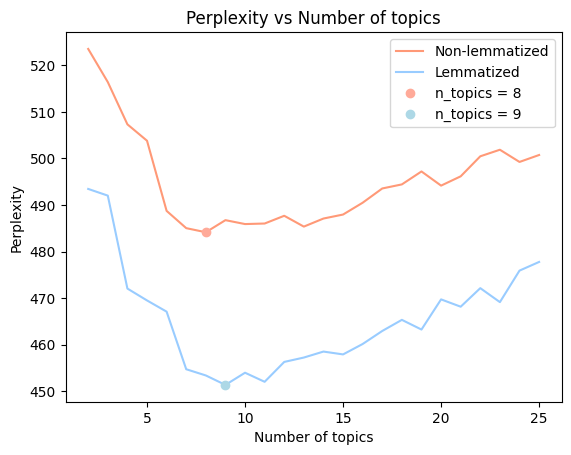

In [155]:
import matplotlib.pyplot as plt
import numpy as np

perplexities = np.array(perplexities)
perplexities_lemmatized = np.array(perplexities_lemmatized)

min_perplexity = min(perplexities)
min_perplexity_index = perplexities.argmin()

min_perplexity_lemmatized = min(perplexities_lemmatized)
min_perplexity_lemmatized_index = perplexities_lemmatized.argmin()



# plot perplexities for lemmatized stories and non-lemmatized stories
plt.plot(range(2, 26), perplexities, label="Non-lemmatized", color='#FF9977')
plt.plot(range(2, 26), perplexities_lemmatized, label="Lemmatized", color='#99CCFF')
plt.xlabel("Number of topics")
plt.ylabel("Perplexity")
plt.title("Perplexity vs Number of topics")
# mark the minimum perplexity
plt.plot(min_perplexity_index+2, min_perplexity, 'ro', label="n_topics = " + str(min_perplexity_index+2), color='#FFAA99')
plt.plot(min_perplexity_lemmatized_index+2, min_perplexity_lemmatized, 'ro', label="n_topics = " + str(min_perplexity_lemmatized_index+2), color='lightblue')
plt.legend()
plt.show()
